Train a Vision Transformer for small datasets with Reconstructed and Latent Images of CVAE from SCAN dataset

In [1]:
!nvidia-smi

Sun Feb 23 04:53:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, ops
from keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

Data Loading and Preprocessing

In [4]:
base_dir = 'https://console.cloud.google.com/storage/browser/admri-bucket?project=myproject2-437608'


In [5]:
from google.cloud import storage

# Initialize the storage client
client = storage.Client()

# Access the bucket
bucket_name = 'admri-bucket'
bucket = client.get_bucket(bucket_name)

In [6]:
# Loading Data

categories = ['CN', 'EMCI', 'MCI', 'LMCI', 'AD']
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
NUM_CLASSES = 5

# Function to load and preprocess images from GCP bucket

def load_images_from_bucket(bucket, categories):
    adni_x, adni_y = [], []
    scan_x, scan_y = [], []

    for category in categories:
        class_num = categories.index(category)
        prefix = f'{category}/'
        blobs = bucket.list_blobs(prefix=prefix)

        for blob in blobs:
            try:
                img_data = blob.download_as_bytes()
                img_array = tf.image.decode_image(img_data, channels=1)
                img_array = tf.image.resize(img_array, [IMAGE_SIZE, IMAGE_SIZE])
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)

                if "ADNI" in blob.name:
                    adni_x.append(img_array)
                    adni_y.append(class_num)
                elif "NACC" in blob.name:
                    scan_x.append(img_array)
                    scan_y.append(class_num)

            except Exception as e:
                print(f"Error loading image {blob.name}: {e}")

    return np.array(adni_x), np.array(adni_y), np.array(scan_x), np.array(scan_y)

# Loading data from GCP bucket
adni_x_full, adni_y_full, scan_x_full, scan_y_full = load_images_from_bucket(bucket, categories)

adni_x_full, adni_y_full = shuffle(adni_x_full, adni_y_full)
scan_x_full, scan_y_full = shuffle(scan_x_full, scan_y_full)

# Split data into training and test sets
adni_x_train, adni_x_test, adni_y_train, adni_y_test = train_test_split(adni_x_full, adni_y_full, test_size=0.15, random_state=42)
scan_x_train, scan_x_test, scan_y_train, scan_y_test = train_test_split(scan_x_full, scan_y_full, test_size=0.15, random_state=42)

In [7]:
# Shape of ADNI x_train, y_train, x_test, y_test

print(f"x_full shape: {adni_x_full.shape} - y_full shape: {adni_y_full.shape}")
print(f"x_train shape: {adni_x_train.shape} - y_train shape: {adni_y_train.shape}")
print(f"x_test shape: {adni_x_test.shape} - y_test shape: {adni_y_test.shape}")

x_full shape: (11942, 256, 256, 1) - y_full shape: (11942,)
x_train shape: (10150, 256, 256, 1) - y_train shape: (10150,)
x_test shape: (1792, 256, 256, 1) - y_test shape: (1792,)


In [8]:
# Shape of SCAN x_train, y_train, x_test, y_test

print(f"x_full shape: {scan_x_full.shape} - y_full shape: {scan_y_full.shape}")
print(f"x_train shape: {scan_x_train.shape} - y_train shape: {scan_y_train.shape}")
print(f"x_test shape: {scan_x_test.shape} - y_test shape: {scan_y_test.shape}")

x_full shape: (2058, 256, 256, 1) - y_full shape: (2058,)
x_train shape: (1749, 256, 256, 1) - y_train shape: (1749,)
x_test shape: (309, 256, 256, 1) - y_test shape: (309,)


In [9]:
# Preprocessing function

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 1))
    return array

In [10]:
# Normalizing and reshaping the data

adni_x_train = preprocess(adni_x_train)
adni_x_test = preprocess(adni_x_test)

scan_x_train = preprocess(scan_x_train)
scan_x_test = preprocess(scan_x_test)

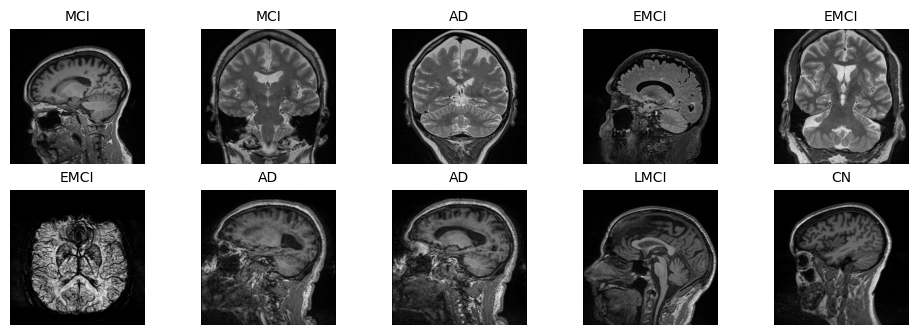

In [11]:
# Displaying the train data
n=5
plt.figure(figsize=(10, 4))

# Plot adni_x_train images

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(adni_x_train[i], cmap='gray')
    plt.title(f"{categories[adni_y_train[i]]}", fontsize=10)
    plt.axis("off")

# Plot scan_x_train images
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(scan_x_train[i], cmap='gray')
    plt.title(f"{categories[scan_y_train[i]]}", fontsize=10)
    plt.axis("off")

plt.subplots_adjust(left=0.05, right=0.95, top=0.85, wspace=0.4)
plt.show()


CVAE

In [12]:
# Creating a sampling layer for the VAE latent space

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the image."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [13]:
# Building the CVAE

latent_dim = 64

# Encoder
encoder_inputs = keras.Input(shape=(256, 256, 1))  # Input shape 256x256x1
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # Downsample to 128x128x32
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 64x64x64
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 32x32x128
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 16x16x256
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 8x8x512
x = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 4x4x1024

# Variational Encoder component for retrieving latent vector z
x2 = layers.Flatten()(x)  # Flatten to (4*4*1024) = 16384 units
x2 = layers.Dense(512, activation="relu")(x2)  # Dense layer with 512 units

z_mean = layers.Dense(latent_dim, name="z_mean")(x2)  # z_mean for latent space
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x2)  # z_log_var for latent space
z = Sampling()([z_mean, z_log_var])  # Sampling layer using (z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Decoder
x = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 8x8x1024
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 16x16x512
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 32x32x256
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 64x64x128
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 128x128x64
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 256x256x32
x = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # Output layer with shape 256x256x1


# Variational Decoder component For Resizing latent vector z for ViT input
latent_inputs = keras.Input(shape=(latent_dim,))  # Latent space input of size 64
x3 = layers.Dense(4 * 4 * 1024, activation="relu")(latent_inputs)  # Dense layer to match the flattened size from encoder
x3 = layers.Reshape((4, 4, 1024))(x3)                               # Reshape to 4x4x1024
x3 = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 8x8x1024
x3 = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 16x16x512
x3 = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 32x32x256
x3 = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 64x64x128
x3 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 128x128x64
x3 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 256x256x32
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x3)  # Output layer (256x256x1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 1024)     │      4,719,616 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      8,389,120 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         32,832 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         32,832 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,742,400 (56.24 MB)

 Trainable params: 14,742,400 (56.24 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       1,064,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 8, 8, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 512)         │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 128, 128, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 256, 256, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 256, 256, 1)         │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,789,761 (64.05 MB)

 Trainable params: 16,789,761 (64.05 MB)

 Non-trainable params: 0 (0.00 B)

Getting Latent Vectors from the Autoencoder

In [14]:
# Defining the CVAE with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
# Building and compiling the CVAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [16]:
# Training the CVAE
vae.fit(scan_x_train, epochs=100, batch_size=128)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - kl_loss: 0.1679 - loss: 42050.5234 - reconstruction_loss: 42050.3594
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 0.5571 - loss: 28753.2500 - reconstruction_loss: 28752.6934
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 0.6991 - loss: 26590.7812 - reconstruction_loss: 26590.0820
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - kl_loss: 1.4588 - loss: 25875.6562 - reconstruction_loss: 25874.1973
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 6.0848 - loss: 25434.4570 - reconstruction_loss: 25428.3711
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 9.0210 - loss: 25327.1250 - reconstruction_loss: 25318.1055
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 29.1649 - loss: 25156.9863 - reconstruction_loss: 25127.8223
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - kl_loss: 38.6388 - loss: 24802.8398 - reconstruction_loss: 24764.1992
Epoch 9/

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step


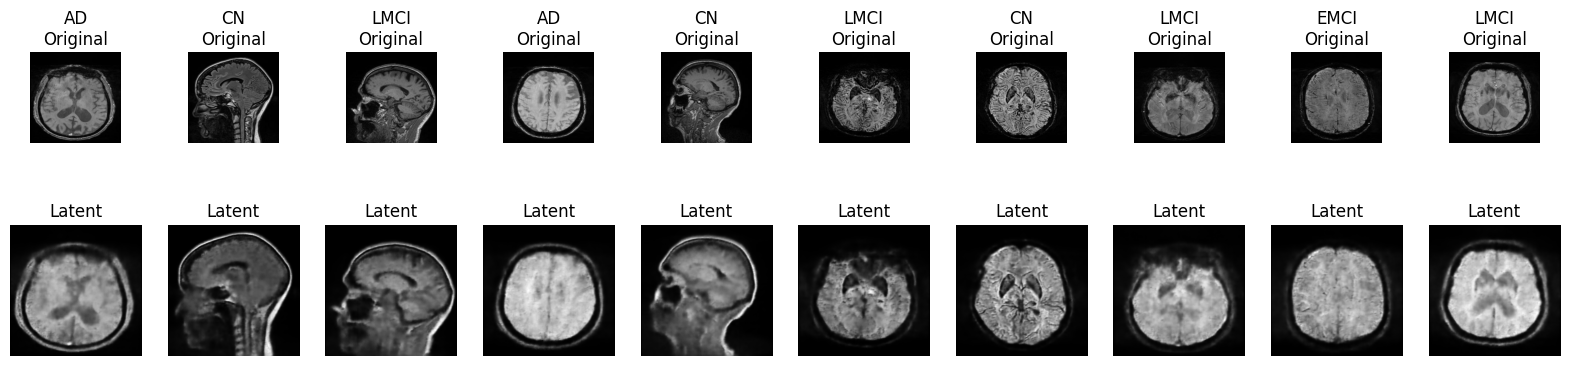

In [17]:
# Evaluating the model on the test set
vae_predictions = vae.decoder.predict(vae.encoder.predict(scan_x_test)[2], verbose=0)

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display x_test
    ax = plt.subplot(3, n, i + 1)
    plt.imshow((scan_x_test[i] / 255.0))
    plt.gray()
    plt.title(categories[scan_y_test[i]] + "\nOriginal", fontsize=12)
    plt.axis("off")

    # Display latent of x_test
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(vae_predictions[i])
    plt.gray()
    plt.title("Latent", fontsize=12)
    plt.axis("off")

plt.show()

In [18]:
# Using VAE Encoder, get the latent representations (z) for the x_train dataset
z_mean, z_log_var, z = vae.encoder.predict(scan_x_train, verbose=0)

# Using VAE Decoder, reconstruct the latent vectors (z) to match the image shape
latent_x_train = vae.decoder.predict(z, verbose=0)

In [19]:
z.shape

(1749, 64)

In [20]:
latent_x_train.shape

(1749, 256, 256, 1)

Getting Reconstructed Inputs from the Autoencoder

In [21]:
# Autoencoder for image reconstruction
autoencoder = Model(encoder_inputs, x)

# Compiling the autoencoder
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [22]:
# Training the autoencoder

autoencoder.fit(
    x=scan_x_train,
    y=scan_x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1352 - loss: 0.6608 - val_accuracy: 0.1415 - val_loss: 0.4732
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.1469 - loss: 0.4371 - val_accuracy: 0.1415 - val_loss: 0.4043
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1469 - loss: 0.3887 - val_accuracy: 0.1415 - val_loss: 0.3785
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.1469 - loss: 0.3714 - val_accuracy: 0.1415 - val_loss: 0.3706
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1469 - loss: 0.3651 - val_accuracy: 0.1415 - val_loss: 0.3673
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1469 - loss: 0.3622 - val_accuracy: 0.1415 - val_loss: 0.3652
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1469 - loss: 0.3602 - val_accuracy: 0.1415 - val_loss: 0.3633
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1469 - loss: 0.3584 - val_accura

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


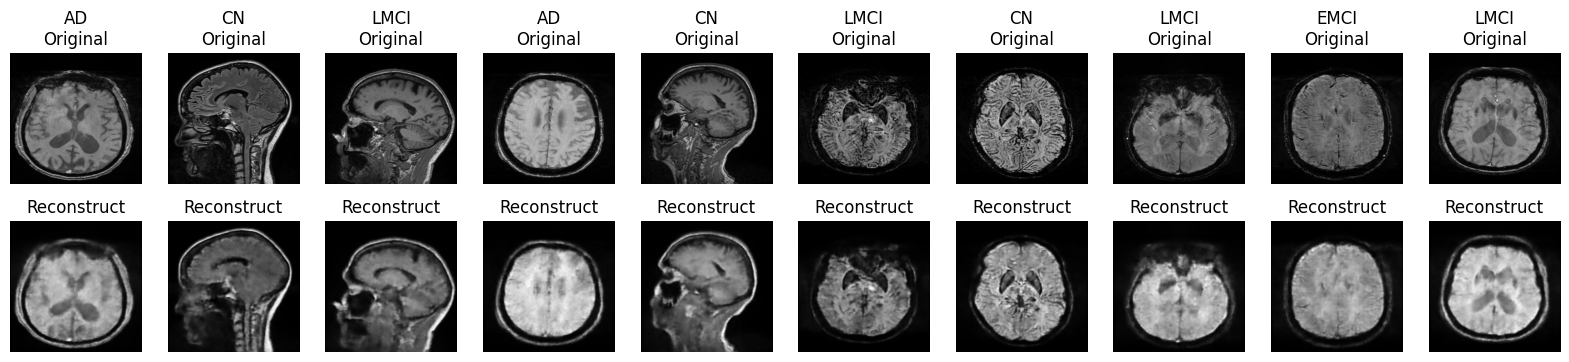

In [23]:
# Evaluating the model on the test set
ae_predictions = autoencoder.predict(scan_x_test)

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original x_test
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((scan_x_test[i] / 255.0))
    plt.gray()
    plt.title(categories[scan_y_test[i]] + "\nOriginal", fontsize=12)
    plt.axis("off")

    # Display reconstructed x_test
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ae_predictions[i])
    plt.gray()
    plt.title("Reconstruct", fontsize=12)
    plt.axis("off")

plt.show()

In [24]:
# Reconstructing x_train

reconstructed_x_train = autoencoder.predict(scan_x_train)
reconstructed_x_train.shape

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


(1749, 256, 256, 1)

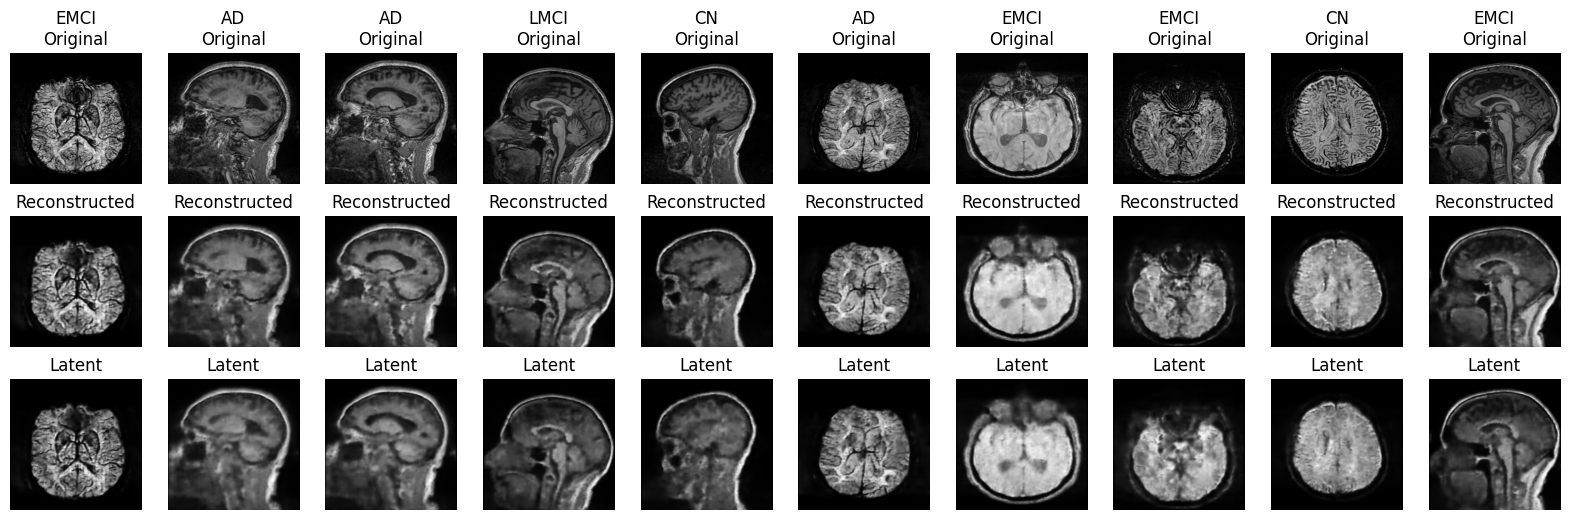

In [25]:
# Displaying the three image sets

n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # Display original x_train
    ax = plt.subplot(3, n, i + 1)
    plt.imshow((scan_x_train[i] / 255.0))
    plt.title(categories[scan_y_train[i]] + "\nOriginal", fontsize=12)
    plt.axis("off")

    # Display reconstructed x_train
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_x_train[i])
    plt.title("Reconstructed", fontsize=12)
    plt.axis("off")

    # Display latent x_train
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(latent_x_train[i])
    plt.title("Latent", fontsize=12)
    plt.axis("off")

plt.show()

VIT

In [26]:
# Configuring Hyperparameters

INPUT_SHAPE = (256, 256, 1)

# Augmentation
IMAGE_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
EPOCHS = 400
BATCH_SIZE = 256
BUFFER_SIZE = 512

# Architecture
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [27]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(latent_x_train)
data_augmentation.layers[0].adapt(reconstructed_x_train)


ViT

In [28]:
# Implementing Shifted Patch Tokenization

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patch embed the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


ORIGINAL


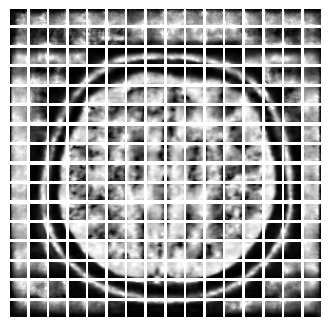

LEFT-UP


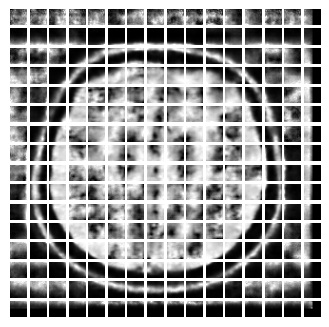

LEFT-DOWN


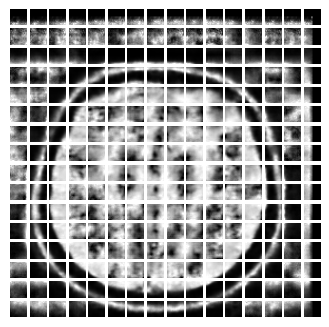

RIGHT-UP


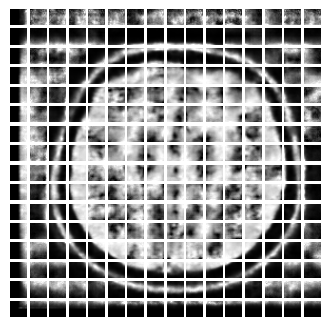

RIGHT-DOWN


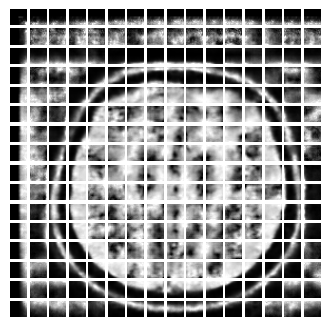

In [29]:
# Visualizing the patches

# Geting a random image and resizing it
image = reconstructed_x_train[np.random.choice(range(reconstructed_x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# This takes an image and divides into patches as in the original ViT paper
# (token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
# (token, patch) = (token[0], patch[0])
# n = patch.shape[0]
# count = 1
# plt.figure(figsize=(4, 4))
# for row in range(n):
#     for col in range(n):
#         plt.subplot(n, n, count)
#         count = count + 1
#         image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 1))  # Grayscale: 1 channel
#         plt.imshow(image)
#         plt.axis("off")
# plt.show()

# Shifted Patch Tokenization: This layer takes the image,
# shifts it diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 1))  # Grayscale: 1 channel
            plt.imshow(image[..., index], cmap='gray')  # Plot in grayscale
            plt.axis("off")
    plt.show()


In [30]:
# Implementing the positional embedding on encoded patches

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [31]:
# Implementing Multi-Head Self Attention function - locally inside the Vit Transfomer Encoder

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # The initial value is the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [32]:
# Implementing the MLP function - for Transformer Encoder and final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Building the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [33]:
# Defining the function for the ViT classifier

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)

    augmented = data_augmentation(inputs)       # Augmenting data

    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)      # Creating patches

    encoded_patches = PatchEncoder()(tokens)        # Encoding patches with positions

    # Create multiple layers of the Transformer block
    for _ in range(TRANSFORMER_LAYERS):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)   # Layer normalization 1

        # Creating a multi-head attention layer
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Creating a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Adding MLP
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)

    # Dense layer for classifying outputs
    logits = layers.Dense(NUM_CLASSES)(features)

    # Creating the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [34]:
# Creating the ViT classifier and Compiling the model

vit = create_vit_classifier(vanilla=False)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

vit.compile(
        optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [35]:
# Training the ViT with latent_x_train (of ADNI dataset)

vit.fit(
    x=latent_x_train,
    y=scan_y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 841ms/step - accuracy: 0.2207 - loss: 10.4045 - val_accuracy: 0.2800 - val_loss: 2.1435
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.2431 - loss: 2.5546 - val_accuracy: 0.4286 - val_loss: 1.3928
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.3072 - loss: 1.9148 - val_accuracy: 0.6571 - val_loss: 1.1844
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.3499 - loss: 1.6981 - val_accuracy: 0.7200 - val_loss: 1.0551
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.4012 - loss: 1.4704 - val_accuracy: 0.7543 - val_loss: 0.9424
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.4811 - loss: 1.2963 - val_accuracy: 0.8229 - val_loss: 0.7782
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - accuracy: 0.5514 - loss: 1.1235 - val_accuracy: 0.7886 - val_loss: 0.7072
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.6186 - loss: 1.0134 - val_accuracy: 0.8971 -

In [36]:
# Training the ViT with reconstructed_x_train (of ADNI dataset)

history = vit.fit(
    x=reconstructed_x_train,
    y=scan_y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - accuracy: 0.9541 - loss: 0.1926 - val_accuracy: 0.9943 - val_loss: 0.0174
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.9662 - loss: 0.1136 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9505 - loss: 0.1630 - val_accuracy: 0.9943 - val_loss: 0.0272
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9600 - loss: 0.1555 - val_accuracy: 0.9943 - val_loss: 0.0267
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9544 - loss: 0.1532 - val_accuracy: 0.9886 - val_loss: 0.0306
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9609 - loss: 0.1249 - val_accuracy: 0.9943 - val_loss: 0.0327
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9518 - loss: 0.1814 - val_accuracy: 0.9829 - val_loss: 0.0314
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.9636 - loss: 0.1108 - val_accuracy: 0.9943 - v

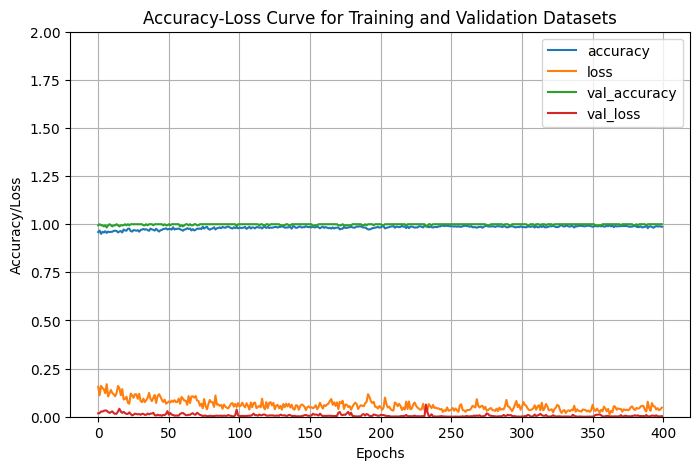

In [37]:
# Accuracy/Loss Curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('Accuracy-Loss Curve for Training and Validation Datasets')
plt.show()

#1. Evaluating the Model on SCAN x_test

In [38]:
# Evaluating the model on the test set

# Accuracy and loss for the test dataset
test_loss, test_acc = vit.evaluate(scan_x_test, scan_y_test)

print('\nAccuracy for Test Dataset: %.4f' % test_acc)
print('\nLoss for Test Dataset: %.4f' % test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9933 - loss: 0.0180

Accuracy for Test Dataset: 0.9935

Loss for Test Dataset: 0.0171


In [39]:
# Getting predictions for test data (getting the highest probability class)

y_pred_probs = vit.predict(scan_x_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step



Classification Report: 
               precision    recall  f1-score   support

          CN       1.00      1.00      1.00        77
        EMCI       0.99      1.00      0.99        68
         MCI       1.00      0.97      0.98        58
        LMCI       0.98      1.00      0.99        50
          AD       1.00      1.00      1.00        56

    accuracy                           0.99       309
   macro avg       0.99      0.99      0.99       309
weighted avg       0.99      0.99      0.99       309



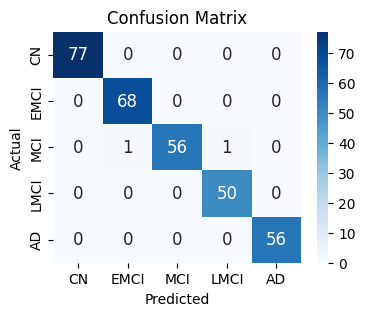

In [40]:
# Classification report
print("\nClassification Report: \n", classification_report(scan_y_test, y_pred, target_names=categories))

# Confusion matrix
cm = confusion_matrix(scan_y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# Compute Sensitivity and Specificity from confusion matrix

# Initialize lists to store results
sensitivity = []
specificity = []

# Calculate metrics for each class
for i in range(len(categories)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)

# Display results
for idx, category in enumerate(categories):
    print(f"{category} - Sensitivity: {sensitivity[idx]:.2f}, Specificity: {specificity[idx]:.2f}")

CN - Sensitivity: 1.00, Specificity: 1.00
EMCI - Sensitivity: 1.00, Specificity: 1.00
MCI - Sensitivity: 0.97, Specificity: 1.00
LMCI - Sensitivity: 1.00, Specificity: 1.00
AD - Sensitivity: 1.00, Specificity: 1.00


In [42]:
# AUC-ROC Curve

# Convert y_test to a one-hot encoding
y_test_binarized = label_binarize(scan_y_test, classes=[0, 1, 2, 3, 4])

# Calculate AUC for each class
auc_values = []
for i in range(y_test_binarized.shape[1]):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_values.append(auc)

# Display per-class AUC
for class_idx, auc_val in enumerate(auc_values):
    print(f"AUC for class {class_idx}: {auc:.4f}")

# Optionally calculate the macro-average AUC
macro_auc = np.mean(auc_values)
print(f"Macro-average AUC: {macro_auc:.4f}")


AUC for class 0: 1.0000
AUC for class 1: 1.0000
AUC for class 2: 1.0000
AUC for class 3: 1.0000
AUC for class 4: 1.0000
Macro-average AUC: 0.9955


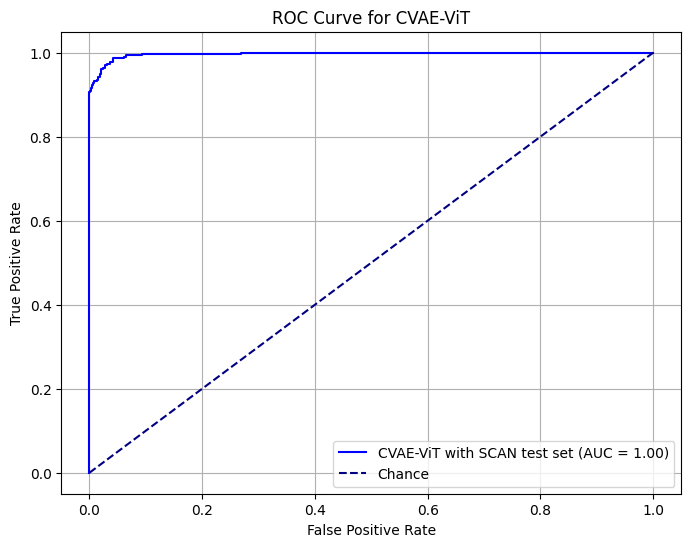

In [43]:
from sklearn.metrics import auc

# Calculate ROC and AUC for the model
fpr_d, tpr_d, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
auc_d = auc(fpr_d, tpr_d)


# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_d, tpr_d, color="blue", label=f"CVAE-ViT with SCAN test set (AUC = {auc_d:.2f})")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CVAE-ViT")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

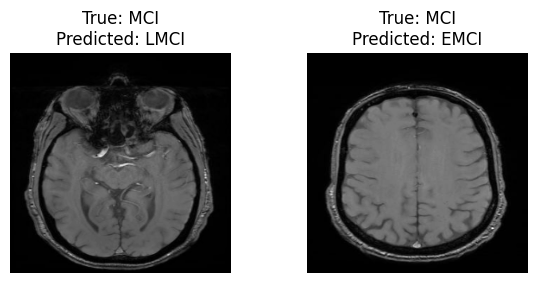

In [44]:
# Displaying the first 20 incorrect predictions

# Finding indices of incorrect predictions
incorrect_indices = np.where(y_pred != scan_y_test)[0]

# Displaying the incorrect predictions
num_incorrect_to_display = min(20, len(incorrect_indices))

plt.figure(figsize=(15, 10))
for i, incorrect_idx in enumerate(incorrect_indices[:num_incorrect_to_display]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(scan_x_test[incorrect_idx])
    plt.title(f"True: {categories[scan_y_test[incorrect_idx]]}\nPredicted: {categories[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#2. Evaluating the Model on ADNI x_test

In [45]:
# Evaluating the model on the test set

# Accuracy and loss for the test dataset
test_loss, test_acc = vit.evaluate(adni_x_test, adni_y_test)

print('\nAccuracy for Test Dataset: %.4f' % test_acc)
print('\nLoss for Test Dataset: %.4f' % test_loss)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1861 - loss: 6.8835

Accuracy for Test Dataset: 0.1897

Loss for Test Dataset: 6.9439


In [46]:
# Getting predictions for test data (getting the highest probability class)

y_pred_probs = vit.predict(adni_x_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step



Classification Report: 
               precision    recall  f1-score   support

          CN       0.21      0.47      0.29       362
        EMCI       0.23      0.04      0.06       389
         MCI       0.13      0.06      0.08       347
        LMCI       0.19      0.31      0.23       360
          AD       0.15      0.06      0.09       334

    accuracy                           0.19      1792
   macro avg       0.18      0.19      0.15      1792
weighted avg       0.18      0.19      0.15      1792



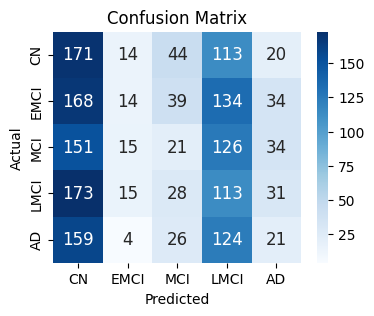

In [47]:
# Classification report
print("\nClassification Report: \n", classification_report(adni_y_test, y_pred, target_names=categories))

# Confusion matrix
cm = confusion_matrix(adni_y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# Compute Sensitivity and Specificity from confusion matrix

# Initialize lists to store results
sensitivity = []
specificity = []

# Calculate metrics for each class
for i in range(len(categories)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)

# Display results
for idx, category in enumerate(categories):
    print(f"{category} - Sensitivity: {sensitivity[idx]:.2f}, Specificity: {specificity[idx]:.2f}")

CN - Sensitivity: 0.47, Specificity: 0.54
EMCI - Sensitivity: 0.04, Specificity: 0.97
MCI - Sensitivity: 0.06, Specificity: 0.91
LMCI - Sensitivity: 0.31, Specificity: 0.65
AD - Sensitivity: 0.06, Specificity: 0.92


In [49]:
# AUC-ROC Curve

# Convert y_test to a one-hot encoding
y_test_binarized = label_binarize(adni_y_test, classes=[0, 1, 2, 3, 4])

# Calculate AUC for each class
auc_values = []
for i in range(y_test_binarized.shape[1]):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_values.append(auc)

# Display per-class AUC
for class_idx, auc_val in enumerate(auc_values):
    print(f"AUC for class {class_idx}: {auc:.4f}")

# Optionally calculate the macro-average AUC
macro_auc = np.mean(auc_values)
print(f"Macro-average AUC: {macro_auc:.4f}")


AUC for class 0: 0.5118
AUC for class 1: 0.5118
AUC for class 2: 0.5118
AUC for class 3: 0.5118
AUC for class 4: 0.5118
Macro-average AUC: 0.4983


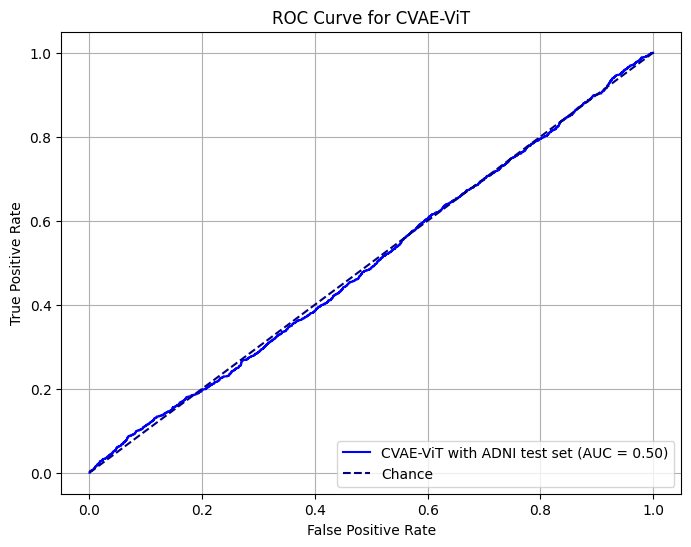

In [50]:
from sklearn.metrics import auc

# Calculate ROC and AUC for the model
fpr_d, tpr_d, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
auc_d = auc(fpr_d, tpr_d)


# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_d, tpr_d, color="blue", label=f"CVAE-ViT with ADNI test set (AUC = {auc_d:.2f})")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CVAE-ViT")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

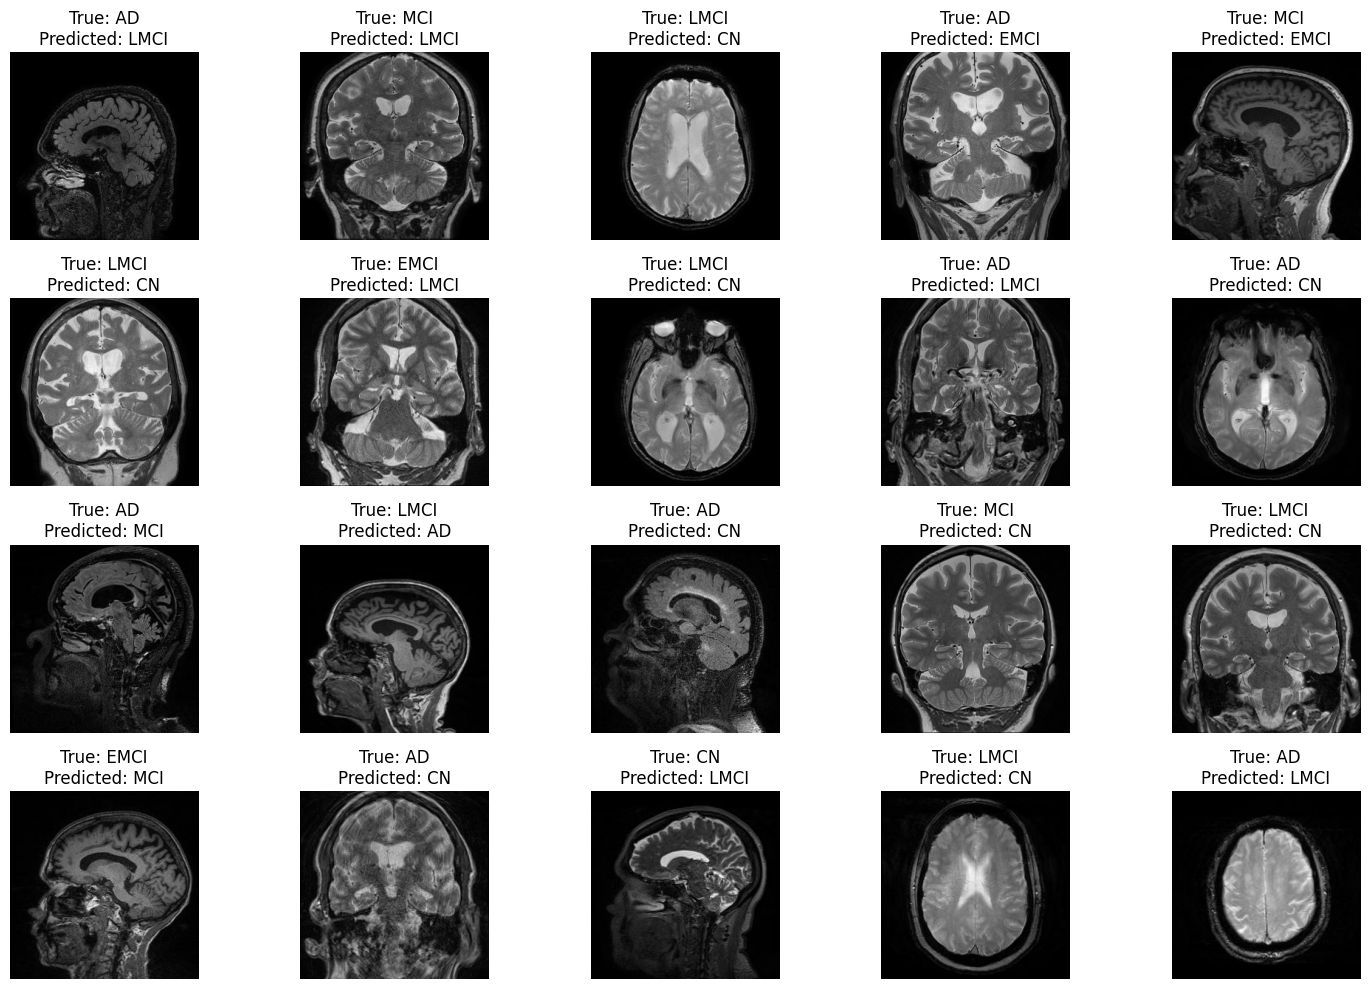

In [51]:
# Displaying the first 20 incorrect predictions

# Finding indices of incorrect predictions
incorrect_indices = np.where(y_pred != adni_y_test)[0]

# Displaying the incorrect predictions
num_incorrect_to_display = min(20, len(incorrect_indices))

plt.figure(figsize=(15, 10))
for i, incorrect_idx in enumerate(incorrect_indices[:num_incorrect_to_display]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(adni_x_test[incorrect_idx])
    plt.title(f"True: {categories[adni_y_test[incorrect_idx]]}\nPredicted: {categories[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Saving the Model

In [ ]:
from google.colab import files

# Save the model temporarily in Colab
model_path = "/content/ViT_CVAE_SCANTrained.keras"
vit.save(model_path)

# Download the saved model
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>